In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from functions import dataToTimeSeries

In [2]:
df = pd.read_excel('./dataframes/downtimes.xlsx')
df.head()

,LineID,LineDescription,ResourceID,ResourceNameNeu,ResourceName,DisplayOrder,StopGroupID,StopGroupNameNeu,StopGroupName,StopGroupDisabled,...,StopReasonDisabled,StopReasonReportExclude,PEStopGroupID,PEStopGroupNameNeu,PEStopGroupName,HarmoniseSourceID,FromTime,ToTime,DurationSec,Comment
0,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-04 16:02:47.000,2022-01-04 16:22:29.000,1182,NaN
1,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,5.0,Group 5 (Stop for tapping),Group 5 (Stop for tapping),1001,2022-01-05 10:04:00.000,2022-01-05 10:49:00.000,2700,NaN
2,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 10:49:00.000,2022-01-05 11:10:00.000,1260,SK Unterkammer
3,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 11:10:00.000,2022-01-05 11:24:00.000,840,SK Band Motor Rotation
4,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 12:04:00.000,2022-01-05 12:37:00.000,1980,2 Lamellen getauscht


In [3]:
df.shape

(1902, 23)

In [4]:
df['ResourceNameNeu'].unique()

array(['Production stop', 'Melting stop', 'Planned stop', 'Filter Bypass',
       'Emergency Cimney'], dtype=object)

In [5]:
df = df[(df['LineDescription']=='GLA 03') & (df['ResourceNameNeu'] == 'Production stop')]
df.shape

(808, 23)

In [8]:
df[:20]

,LineID,LineDescription,ResourceID,ResourceNameNeu,ResourceName,DisplayOrder,StopGroupID,StopGroupNameNeu,StopGroupName,StopGroupDisabled,...,StopReasonDisabled,StopReasonReportExclude,PEStopGroupID,PEStopGroupNameNeu,PEStopGroupName,HarmoniseSourceID,FromTime,ToTime,DurationSec,Comment
899,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-03 10:00:00.000,2022-01-03 10:18:00.000,1080,NaN
900,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,7.0,Group 7 (Stop for product change),Group 7 (Stop for product change),1001,2022-01-04 05:58:38.000,2022-01-04 06:21:26.000,1368,NaN
901,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,5.0,Group 5 (Stop for tapping),Group 5 (Stop for tapping),1001,2022-01-05 02:46:18.000,2022-01-05 03:31:00.000,2682,NaN
902,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 03:31:00.000,2022-01-05 04:00:00.000,1740,NaN
903,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 23:25:34.000,2022-01-05 23:46:02.000,1228,NaN
904,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-05 23:51:34.000,2022-01-06 00:02:22.000,648,NaN
905,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-06 00:10:28.000,2022-01-06 00:16:46.000,378,NaN
906,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-06 08:39:56.000,2022-01-06 08:58:35.000,1119,Verstopper.
907,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,5.0,Group 5 (Stop for tapping),Group 5 (Stop for tapping),1001,2022-01-07 04:32:06.000,2022-01-07 05:42:36.000,4230,NaN
908,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2022-01-07 06:35:57.000,2022-01-07 06:41:30.000,333,Spinnmaschine ausgefallen


In [9]:
df = df[['FromTime', 'ToTime']]

In [11]:
df['FromTime'] = pd.to_datetime(df['FromTime']).dt.floor('s')
df['ToTime'] = pd.to_datetime(df['ToTime']).dt.floor('s')
df.set_index('FromTime', inplace=True)

In [12]:
df = df[df.index < pd.Timestamp('2023-01-01 00:00:00')]

In [14]:
df[:15]

,ToTime
FromTime,
2022-01-03 10:00:00,2022-01-03 10:18:00
2022-01-04 05:58:38,2022-01-04 06:21:26
2022-01-05 02:46:18,2022-01-05 03:31:00
2022-01-05 03:31:00,2022-01-05 04:00:00
2022-01-05 23:25:34,2022-01-05 23:46:02
2022-01-05 23:51:34,2022-01-06 00:02:22
2022-01-06 00:10:28,2022-01-06 00:16:46
2022-01-06 08:39:56,2022-01-06 08:58:35
2022-01-07 04:32:06,2022-01-07 05:42:36


In [15]:
df_changed = df.resample('1S').asfreq().fillna(method="ffill")
df_changed.head()

,ToTime
FromTime,
2022-01-03 10:00:00,2022-01-03 10:18:00
2022-01-03 10:00:01,2022-01-03 10:18:00
2022-01-03 10:00:02,2022-01-03 10:18:00
2022-01-03 10:00:03,2022-01-03 10:18:00
2022-01-03 10:00:04,2022-01-03 10:18:00


In [16]:
df_changed['downtime'] = df_changed.apply(lambda row: 1 if row['ToTime'] > row.name else 0, axis=1)
# df_changed['downtime'] = [1 if row['ToTime'] > index else 0 for index, row in df_changed.iterrows()]

In [17]:
df_changed.downtime.value_counts()

0    24193484
1     6424517
Name: downtime, dtype: int64

In [18]:
df_downtimes = df_changed[df_changed.index < pd.Timestamp('2023-01-01 00:00:00')]

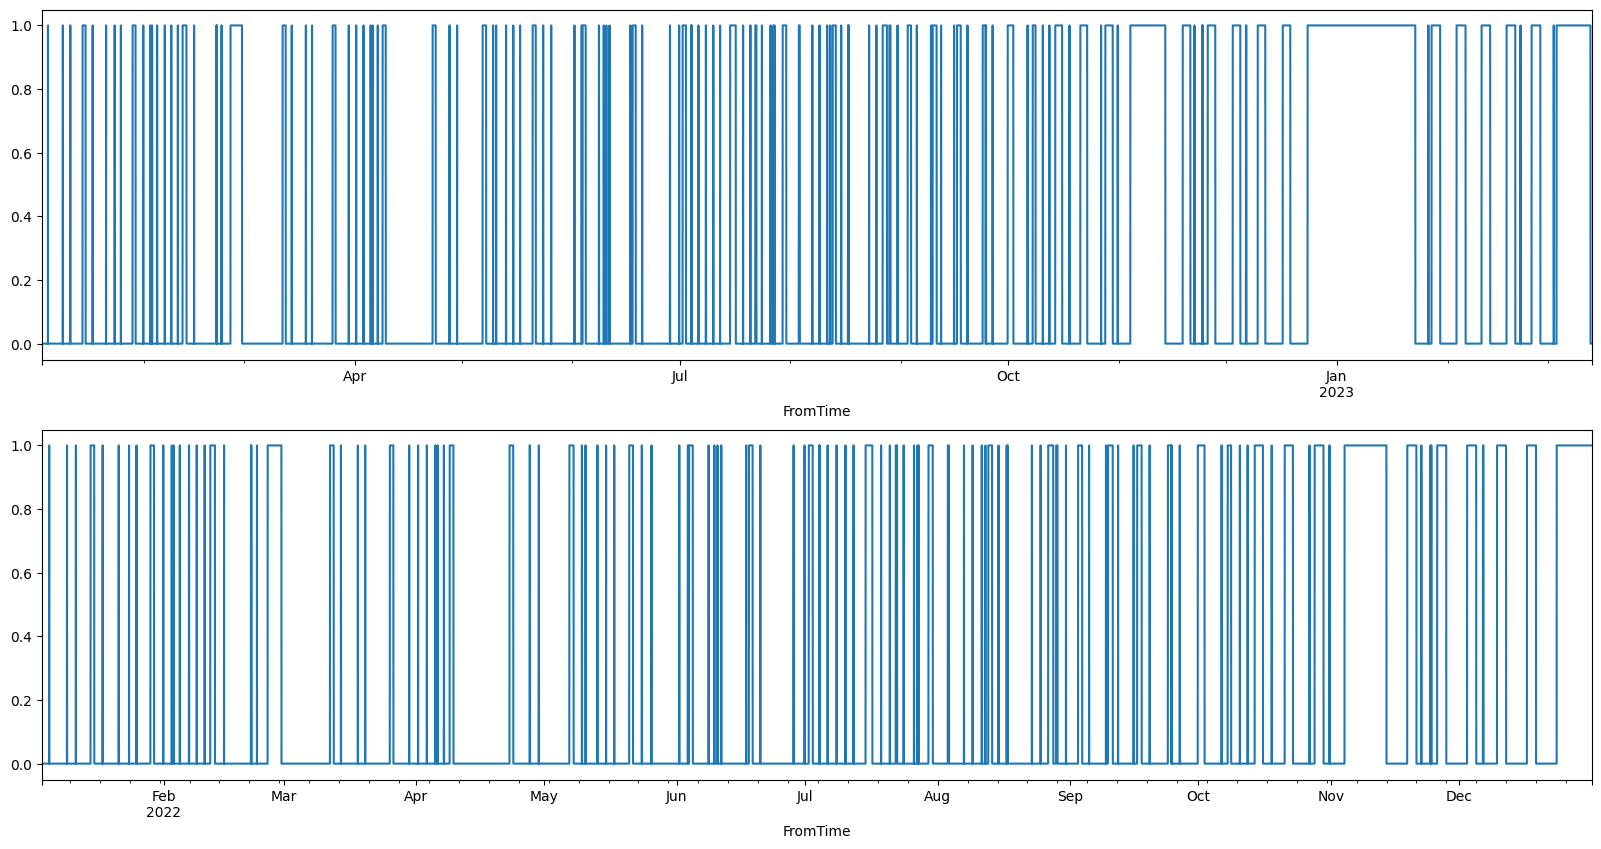

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

df_changed['downtime'].plot(ax =ax1)
df_downtimes['downtime'].plot(ax=ax2)
plt.show()

<Axes: ylabel='downtime'>

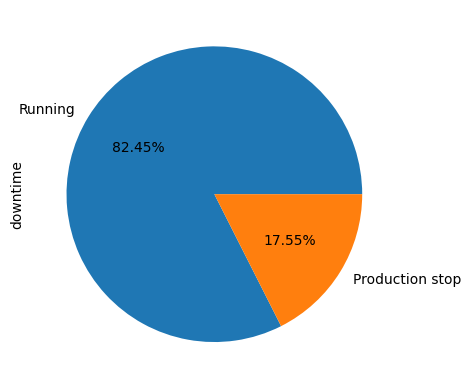

In [13]:
counts = df_downtimes.downtime.value_counts()
labels = ['Running', 'Production stop']
counts.plot.pie(autopct='%.2f%%', labels = labels)

<Axes: ylabel='downtime'>

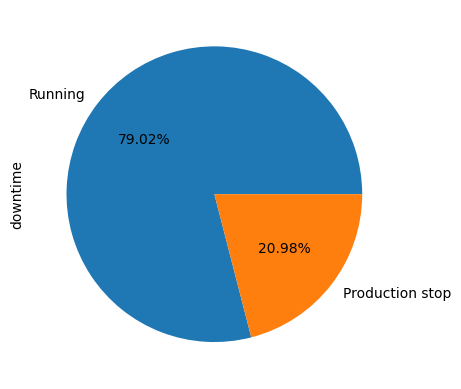

In [19]:
counts = df_changed.downtime.value_counts()
labels = ['Running', 'Production stop']
counts.plot.pie(autopct='%.2f%%', labels = labels)

In [20]:
df_downtimes= df_downtimes[['downtime']]

In [21]:
df_downtimes.index.names = ['DateTime']

In [22]:
df_downtimes

,downtime
DateTime,
2022-01-03 10:00:00,1
2022-01-03 10:00:01,1
2022-01-03 10:00:02,1
2022-01-03 10:00:03,1
2022-01-03 10:00:04,1
...,...
2022-12-23 18:59:56,0
2022-12-23 18:59:57,0
2022-12-23 18:59:58,0


In [19]:
df_downtimes.to_csv('downtimes_2022.csv')

In [17]:
df_changed.to_csv('./dataframes/downtimes_2022_ms.csv')